In [501]:
### Needed modules :

## Standard :
# Full imports :
import os
import gc
import copy
import sklearn

# Aliased imports :
import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt

# Partial Imports :
from sys import getsizeof
from typing import List, Tuple
from scipy import stats
from functools import reduce

## User-defined :
import Preprocessing as pre
import Drive

In [502]:
# Function definitions :

def time_indexed_df(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Take a return a time-indexed dataframe.
    df1 paramater should contain a column called 'dateTime',
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    """
    _tmp = copy.deepcopy(df1)
    _tmp.index = df1.dateTime
    _tmp.drop('dateTime', axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    gc.collect()
    return _tmp

def fill_nas(df1: pd.core.frame.DataFrame, 
             col_names: List[str] = ['activeInsulin', 'carbs', 'insulin', 'trend'],
             fill_with=0) -> pd.core.frame.DataFrame:
    """  return a new dataframe
    """
    _tmp = copy.deepcopy(df1)
    for name in col_names:
        _tmp[name] = df1[name].fillna(0)
    gc.collect()
    return _tmp

def classify(value: float, limits: Tuple[float, float] = (70, 140)) -> str:
    """ value: Numerical value
        limits: Tuple (lower_boundary, high_boundary)
        
        Returns:
            'hypo'  if value < lower_boundary
            'normo' if lower_boundary <= value <= high_boundary
            'hyper' if value > high_boundary
    """
    if value < limits[0]:
        return 'hypo'
    elif value > limits[1]:
        return 'hyper'
    else:
        return 'normo'
        
def set_hour(df:  pd.core.frame.DataFrame) ->  pd.core.frame.DataFrame:
    """ Return a copy of 'df', 
    adding a column called 'hour'.
    The dataframe 'df' should be time-indexed.
    """
    _tmp = copy.deepcopy(df)
    _tmp.loc[:,'hour'] = list(
                             map(
                                lambda x: x.hour, df.index
                                )
                             )
    gc.collect()
    return _tmp
        
    
def tag_glycaemiae(df:  pd.core.frame.DataFrame, 
                   column_name: str = 'IG') ->  pd.core.frame.DataFrame:
    """ Return a copy of 'df', 
    adding a column called 'tag'.
    See help(classify) .
    Optional param:
        column_name - containing the name of the column
                        of glycaemic values
        default : 'IG'
    """
    _tmp = copy.deepcopy(df)
    _tmp.loc[:,'tag'] = list(
                             map(
                                classify, df[column_name]
                                )
                            )
    gc.collect()
    return _tmp

In [503]:
d = Drive.Drive()

In [504]:
file_name = 'journal.jl'
file_path = os.path.join('data', file_name)
d.download(file_name   = file_name, 
           target_name = file_path
          )

True

In [505]:
pre.file_filter(file_path)

In [506]:
ls data/

journal_filtered.jl  journal.jl


In [507]:
_raw = pd.read_json(file_path, lines=True)
len(_raw)

229

In [508]:
#_raw[_raw.index.duplicated()]

In [509]:
undesired_columns = [ 
    'LOT',
    'REF', 
    'initSuccess', 
    'secondRound',
    'food'
]

In [510]:
_tmp = (
        _raw.drop(undesired_columns, axis=1)
       ).loc[
                (_raw['type'] == 'data') |
                (_raw['type'] == 'event')
            ]

In [511]:
_t_data = time_indexed_df(_tmp)
_tmp.head()

,BG,IG,activeInsulin,carbs,dateTime,details,insulin,trend,type
0,227.0,226.0,NaN,0.0,2019-02-07 00:27:00,Normal,1.05,0.0,data
1,NaN,190.0,NaN,NaN,2019-02-07 01:26:00,Normal,NaN,NaN,data
2,NaN,174.0,NaN,NaN,2019-02-07 08:49:00,Wake,NaN,0.0,event
5,NaN,148.0,NaN,NaN,2019-02-07 02:24:00,Normal,NaN,NaN,data
6,NaN,131.0,NaN,NaN,2019-02-07 03:14:00,Normal,NaN,NaN,data


In [512]:
_t_data.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type
dateTime,,,,,,,,
2019-02-07 00:27:00,227.0,226.0,NaN,0.0,Normal,1.05,0.0,data
2019-02-07 01:26:00,NaN,190.0,NaN,NaN,Normal,NaN,NaN,data
2019-02-07 02:24:00,NaN,148.0,NaN,NaN,Normal,NaN,NaN,data
2019-02-07 03:14:00,NaN,131.0,NaN,NaN,Normal,NaN,NaN,data
2019-02-07 04:24:00,NaN,118.0,NaN,NaN,Normal,NaN,NaN,data


In [513]:
data = fill_nas(_t_data)
data.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type
dateTime,,,,,,,,
2019-02-07 00:27:00,227.0,226.0,0.0,0.0,Normal,1.05,0.0,data
2019-02-07 01:26:00,NaN,190.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 02:24:00,NaN,148.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 03:14:00,NaN,131.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 04:24:00,NaN,118.0,0.0,0.0,Normal,0.00,0.0,data


In [514]:
data2 = copy.deepcopy(data)

In [515]:
data2['BG'] = list( 
                    map(
                         lambda x, y: x if not np.isnan(x) else y, data['IG'], data['BG']
                       )
                  )                 

In [516]:
data2['IG'] = list( 
                    map(
                         lambda x, y: x if not np.isnan(x) else y, data['IG'], data['BG']
                       )
                  )  

In [517]:
data2.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type
dateTime,,,,,,,,
2019-02-07 00:27:00,226.0,226.0,0.0,0.0,Normal,1.05,0.0,data
2019-02-07 01:26:00,190.0,190.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 02:24:00,148.0,148.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 03:14:00,131.0,131.0,0.0,0.0,Normal,0.00,0.0,data
2019-02-07 04:24:00,118.0,118.0,0.0,0.0,Normal,0.00,0.0,data


In [518]:
data2.isna().sum()

BG               2
IG               2
activeInsulin    0
carbs            0
details          0
insulin          0
trend            0
type             0
dtype: int64

In [528]:
data3 = data2.dropna()

In [520]:
data4 = data3[ data3.carbs != 0 ]

In [527]:
data3 = set_hour(data3)
data3 = tag_glycaemiae(data3)
data3.head()

,BG,IG,activeInsulin,carbs,details,insulin,trend,type,hour,tag
dateTime,,,,,,,,,,
2019-02-07 00:27:00,226.0,226.0,0.0,0.0,Normal,1.05,0.0,data,0,hyper
2019-02-07 01:26:00,190.0,190.0,0.0,0.0,Normal,0.00,0.0,data,1,hyper
2019-02-07 02:24:00,148.0,148.0,0.0,0.0,Normal,0.00,0.0,data,2,hyper
2019-02-07 03:14:00,131.0,131.0,0.0,0.0,Normal,0.00,0.0,data,3,normo
2019-02-07 04:24:00,118.0,118.0,0.0,0.0,Normal,0.00,0.0,data,4,normo


In [529]:
data3.loc[:,'hour'] = list(map(
                        lambda x: x.hour, data3.index
                        )
                    )
data3.loc[:, 'tag'] = list(map(
                                classify, data3['IG']
                        )
                    )
data3.head()

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,BG,IG,activeInsulin,carbs,details,insulin,trend,type,hour,tag
dateTime,,,,,,,,,,
2019-02-07 00:27:00,226.0,226.0,0.0,0.0,Normal,1.05,0.0,data,0,hyper
2019-02-07 01:26:00,190.0,190.0,0.0,0.0,Normal,0.00,0.0,data,1,hyper
2019-02-07 02:24:00,148.0,148.0,0.0,0.0,Normal,0.00,0.0,data,2,hyper
2019-02-07 03:14:00,131.0,131.0,0.0,0.0,Normal,0.00,0.0,data,3,normo
2019-02-07 04:24:00,118.0,118.0,0.0,0.0,Normal,0.00,0.0,data,4,normo


/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [522]:
data3['details'].value_counts()

Normal            100
Postprandial       30
Postcorrection      8
Wake                5
Sleep               3
Post-Exercice       2
Pre-Exercice        1
Excercice           1
Dual                1
Name: details, dtype: int64

In [523]:
data4.index.map(lambda x: x)

DatetimeIndex(['2019-02-07 09:24:00', '2019-02-07 12:53:00',
               '2019-02-07 17:39:00', '2019-02-07 18:13:00',
               '2019-02-07 20:41:00', '2019-02-08 12:41:00',
               '2019-02-08 20:00:00', '2019-02-09 10:52:00',
               '2019-02-09 17:05:00', '2019-02-10 14:07:00',
               '2019-02-10 17:34:00', '2019-02-10 23:47:00',
               '2019-02-11 01:01:00', '2019-02-11 01:36:00',
               '2019-02-11 09:37:00', '2019-02-11 13:14:00',
               '2019-02-11 14:36:00', '2019-02-11 18:01:00',
               '2019-02-12 12:52:00', '2019-02-12 21:06:00',
               '2019-02-13 09:09:00', '2019-02-13 12:54:00',
               '2019-02-13 21:40:00', '2019-02-15 13:29:00',
               '2019-02-15 20:39:00', '2019-02-15 21:47:00',
               '2019-02-16 10:46:00', '2019-02-16 12:49:00',
               '2019-02-16 17:01:00', '2019-02-16 21:01:00',
               '2019-02-16 22:25:00', '2019-02-17 08:58:00',
               '2019-02-

In [444]:
data3[  ]

,BG,IG,activeInsulin,carbs,details,insulin,trend,type,hour,tag
dateTime,,,,,,,,,,
2019-02-07 00:27:00,226.0,226.0,0.0,0.0,Normal,1.05,0.0,data,0,hyper
2019-02-07 01:26:00,190.0,190.0,0.0,0.0,Normal,0.00,0.0,data,1,hyper
2019-02-07 02:24:00,148.0,148.0,0.0,0.0,Normal,0.00,0.0,data,2,hyper
2019-02-07 03:14:00,131.0,131.0,0.0,0.0,Normal,0.00,0.0,data,3,normo
2019-02-07 04:24:00,118.0,118.0,0.0,0.0,Normal,0.00,0.0,data,4,normo


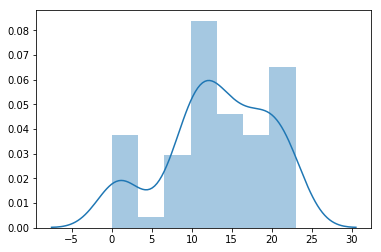

In [403]:
sb.distplot(x)

In [421]:
type(_raw.loc[1, 'dateTime'])

pandas._libs.tslibs.timestamps.Timestamp

In [427]:
list(map(
            classify, data3['IG']
        )
    )

['hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'normo',
 'normo',
 'hypo',
 'hypo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'hyper',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 'normo',
 'normo',
 'normo',
 'normo',
 'hyper',
 'hyper',
 '

In [453]:
print(data3.index[0] - dt.timedelta(hours=2))
data3.index[0] + dt.timedelta(hours=2)

2019-02-06 22:27:00


Timestamp('2019-02-07 02:27:00')

In [466]:
set_hour(data4)

,BG,IG,activeInsulin,carbs,details,insulin,trend,type,hour
dateTime,,,,,,,,,
2019-02-07 09:24:00,184.0,184.0,0.00,30.0,Normal,3.75,0.0,data,9
2019-02-07 12:53:00,133.0,133.0,0.00,56.0,Normal,4.95,0.0,data,12
2019-02-07 17:39:00,99.0,99.0,0.00,12.0,Normal,1.00,0.0,data,17
2019-02-07 18:13:00,101.0,101.0,0.00,10.0,Normal,0.00,0.0,data,18
2019-02-07 20:41:00,140.0,140.0,0.00,75.0,Dual,4.40,0.0,data,20
2019-02-08 12:41:00,120.0,120.0,0.00,90.0,Normal,7.50,0.0,data,12
2019-02-08 20:00:00,100.0,100.0,0.00,70.0,Normal,4.10,0.0,data,20
2019-02-09 10:52:00,105.0,105.0,0.00,85.0,Normal,7.80,0.0,data,10
2019-02-09 17:05:00,90.0,90.0,0.00,90.0,Normal,7.50,0.0,data,17


In [470]:
tag_glycaemiae(_raw)

,BG,IG,LOT,REF,activeInsulin,carbs,dateTime,details,food,initSuccess,insulin,secondRound,trend,type,tag
0,227.0,226.0,NaN,NaN,NaN,0.0,2019-02-07 00:27:00,Normal,None,NaN,1.05,NaN,0.0,data,hyper
1,NaN,190.0,NaN,NaN,NaN,NaN,2019-02-07 01:26:00,Normal,None,NaN,NaN,NaN,NaN,data,hyper
2,NaN,174.0,NaN,NaN,NaN,NaN,2019-02-07 08:49:00,Wake,None,NaN,NaN,NaN,0.0,event,hyper
3,NaN,102.0,NaN,NaN,NaN,NaN,2019-02-07 05:04:00,Suspension before hypo,None,NaN,NaN,NaN,0.0,alarm,normo
4,NaN,98.0,NaN,NaN,NaN,NaN,2019-02-07 06:25:00,Basal resumption,None,NaN,NaN,NaN,0.0,alarm,normo
5,NaN,148.0,NaN,NaN,NaN,NaN,2019-02-07 02:24:00,Normal,None,NaN,NaN,NaN,NaN,data,hyper
6,NaN,131.0,NaN,NaN,NaN,NaN,2019-02-07 03:14:00,Normal,None,NaN,NaN,NaN,NaN,data,normo
7,NaN,118.0,NaN,NaN,NaN,NaN,2019-02-07 04:24:00,Normal,None,NaN,NaN,NaN,NaN,data,normo
8,NaN,184.0,NaN,NaN,NaN,30.0,2019-02-07 09:24:00,Normal,None,NaN,3.75,NaN,0.0,data,hyper
9,NaN,199.0,NaN,NaN,NaN,NaN,2019-02-07 09:30:00,Alert before hyper,None,NaN,NaN,NaN,0.0,alarm,hyper


In [474]:
eval(f'print({(lambda x: x)(5)})')

5


In [478]:
('4,5;5').replace(',', '.').replace(';', ',')

'4.5,5'